In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import  DataLoader, TensorDataset
import mlflow
import os
from torch.utils.tensorboard import SummaryWriter


In [16]:

def get_data_loader():
    # load the dataset
    dataset = pd.read_csv('data/pima-indians-diabetes.csv').to_numpy()

    # split into input (X) and output (y) variables
    X = dataset[:, 0:8]
    y = dataset[:, 8]

    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)

    dataset_xy = TensorDataset(X, y)
    return DataLoader(dataset=dataset_xy, batch_size=16, shuffle=True)



In [17]:

class Net_V1(nn.Module):

    def __init__(self):
        super(Net_V1, self).__init__()
        self.fc1 = nn.Linear(8, 10)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(10, 10)
        self.out = nn.Linear(10, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        x = self.fc1(input_)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = self.out_act(x)
        return x

class Net_V2(nn.Module):

    def __init__(self):
        super(Net_V2, self).__init__()
        self.fc1 = nn.Linear(8, 8)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, 8)
        self.out = nn.Linear(8, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        x = self.fc1(input_)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.out(x)
        x = self.out_act(x)
        return x



In [18]:

def log_scalar(val,name,epoch,mlflow_log=True):
    wirter.add_scalar(name,val,epoch)
    if mlflow_log:
        mlflow.log_metric(name,val)

def log_model_parm(model,step):
    for name,parm in model.named_parameters():
        wirter.add_histogram(name,parm.data,step)


In [19]:

def train(max_ep,model, opt, criterion, train_loader):
    loss_arr=[]
    for i in range(1,max_ep+1):
        loss = train_epoch(model, opt, criterion, train_loader,i)
        loss_arr.extend(loss)
        log_model_parm(model,i)
    return loss_arr


def train_epoch(model, opt, criterion, train_loader,ep_i):
    model.train()
    losses = []
    for idx, data in enumerate(train_loader):
        x_batch,y_batch = data
        x_batch = x_batch.to(device)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat.cpu().squeeze(), y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.data.numpy())
        log_scalar(loss.data.item(),"loss",ep_i*idx,mlflow_log=True)

    return losses



In [20]:


def init_exp(dict_args):


    if dict_args["network"] == "v1":
        net = Net_V1()
    elif dict_args["network"] == "v2":
        net = Net_V2()
    else:
        raise ("bad arg")

    if dict_args["optim"] == "Adam":
        opt = optim.Adam(net.parameters(), lr=dict_args['lr'])
    elif dict_args["optim"] == "SGD":
        opt = optim.SGD(net.parameters(), lr=dict_args['lr'], momentum=0.9)
    else:
        raise ("bad arg")

    if dict_args["loss_function"] == "BCE":
        criterion = nn.BCELoss()
    elif dict_args["loss_function"] == "BCE_sigmoid":
        criterion = nn.BCEWithLogitsLoss()
    else:
        raise ("bad arg")


    e_losses = []
    num_epochs = a = dict_args['num_epochs']
    my_loader = get_data_loader()

    # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes, no need mlflow.end_run()
    with mlflow.start_run():
        mlflow.log_params(dict_args)
        mlflow.set_tag("commit", "cb320e98e7561f8062a29137a00733ab905a5d3e")
        mlflow.set_tag("device", device)

        e_losses = train(num_epochs, net, opt, criterion, my_loader)

        mlflow.log_artifact("data/pima-indians-diabetes.csv")
        mlflow.log_artifact("torch_ex.ipynb")
        mlflow.pytorch.log_model(net, artifact_path="my_net")
        
        
        # make loss plot
        fig, ax = plt.subplots()
        ax.plot(e_losses)

        mlflow.log_figure(fig, 'loss.png')


Using device: cpu


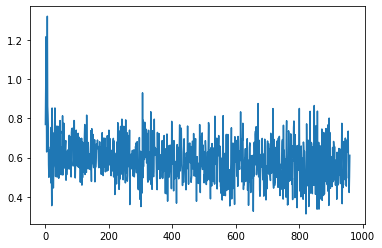

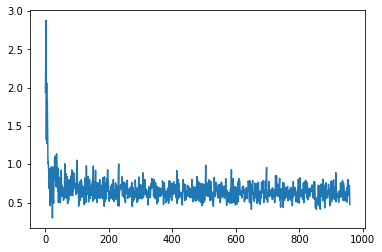

In [21]:
# check if gpu is aviable 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device= 'cpu' # remove this 

print('Using device:', device)
dict_args_param = [
{"id":100,"network":"v1","optim":"Adam","lr":0.001,"loss_function":"BCE",'num_epochs':20},
{"id":101,"network":"v2","optim":"SGD","lr":0.0001,"loss_function":"BCE",'num_epochs':20}
]


for item in dict_args_param:
    # open a tensorboard wirter
    run_name = "_".join([str(k) + '_' + str(v) for k, v in item.items()])
    wirter = SummaryWriter("runs/{}".format(run_name))

    init_exp(item)